In [79]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
import matplotlib as mpl
from astropy.io import fits
from matplotlib.colors import LogNorm

##get the matplotlib style

mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [80]:

# Path to the catalog
filename = "/pscratch/sd/v/virajvm/desi_dwarf_catalogs/dr1/v1.0/desi_dr1_dwarf_catalog.fits"

# Option 1: load the MAIN extension directly as an Astropy Table
main = Table.read(filename, hdu="MAIN")

# Option 2: load the FASTSPEC extension
fastspec = Table.read(filename, hdu="FASTSPEC")

# Check how many entries and columns
print(main)
print(fastspec)


     TARGETID     SURVEY PROGRAM ...       SHAPE_PARAMS       IN_SGA_2020
                                 ...                                     
----------------- ------ ------- ... ------------------------ -----------
39627066986994125    sv1  bright ...  7.1169677 .. -87.195564       False
39627067007963313    sv1  bright ...   1.499708 .. -19.329487       False
39627072187928583    sv1  bright ...   2.3645105 .. -62.52163       False
39627072192121852    sv1  bright ...   2.8253334 .. 40.071945       False
39627077376288706    sv1  bright ...   1.3985701 .. 47.511642       False
39627077380476509    sv1  bright ...   4.0237813 .. -81.53559       False
39627077380481832    sv1  bright ...    2.5720077 .. -70.4573       False
39627082573030107    sv1  bright ...  0.65384763 .. -88.33861       False
39627082589799214    sv1  bright ...  3.8018909 .. -28.123894       False
39627082589803422    sv1  bright ...  2.8531327 .. -48.799778       False
              ...    ...     ... ...  

In [81]:
# List available columns
print(main.colnames)

# Look at units and descriptions for a few example columns
for col in ["RA", "DEC", "LOG_MSTAR_SAGA", "MAG_G"]:
    print(f"{col:20s} | Unit: {main[col].unit} | Description: {main[col].description}")

['TARGETID', 'SURVEY', 'PROGRAM', 'Z', 'DELTACHI2', 'ZWARN', 'RA', 'DEC', 'RA_TARGET', 'DEC_TARGET', 'DESINAME', 'LUMI_DIST_MPC', 'LOG_MSTAR_SAGA', 'LOG_MSTAR_M24', 'MAG_G', 'MAG_R', 'MAG_Z', 'MAG_G_TARGET', 'MAG_R_TARGET', 'MAG_Z_TARGET', 'SAMPLE', 'DWARF_MASKBIT', 'MAG_TYPE', 'PHOTOMETRY_UPDATED', 'SHAPE_PARAMS', 'IN_SGA_2020']
RA                   | Unit: deg | Description: Right Ascension of the galaxy. Same as target catalog, except for galaxies that are reprocessed after identified as likely shredded.
DEC                  | Unit: deg | Description: Declination of the galaxy. Same as target catalog, except for galaxies that are reprocessed after identified as likely shredded.
LOG_MSTAR_SAGA       | Unit: None | Description: Log stellar mass (in Msol) using the LUMI_DIST_MPC luminosity distance and SAGA gr-based approximation
MAG_G                | Unit: mag | Description: g-band magnitude (MW extinction corrected). Same as Tractor photometry, except for galaxies that are reprocess

## MAIN Extension

The `MAIN` extension contains the primary information about each galaxy, including position, photometry, redshift measurements, and catalog-level flags.  

This is the primary table you would typically use for most science analyses.

This extension includes:

- **Target identifiers**: `TARGETID`, `DESINAME`  
- **Survey and program info**: `SURVEY`, `PROGRAM`, `SAMPLE`  
- **Redshift measurements**: `Z`, `DELTACHI2`, `ZWARN`  
- **Sky positions**: `RA`, `DEC`, `RA_TARGET`, `DEC_TARGET`  
- **Photometry**: `MAG_G`, `MAG_R`, `MAG_Z` (and `*_TARGET` for original, potentially shredded measurements)  
- **Stellar mass estimates**: `LOG_MSTAR_SAGA`, `LOG_MSTAR_M24`  
- **Distance measures**: `LUMI_DIST_MPC`  
- **Photometry flags**: `MAG_TYPE`, `PHOTOMETRY_UPDATED`  
- **Galaxy shape parameters**: `SHAPE_PARAMS` (semi-major axis, b/a ratio, position angle)  
- **Catalog cleaning flags**: `DWARF_MASKBIT`

Each column is documented with units, description, and data type in the FITS header. This extension will usually be the primary starting point for querying or filtering your catalog before combining with other extensions like `FASTSPEC`.

We remove objects flagged in the DWARF_MASKBIT. Note: some removed objects may have good photometry, but most are likely problematic measurements. Also, even after these cuts, the catalog may still contain some spurious measurements, especially at the extremes of magnitude, color, or stellar mass (low and high). Use caution when analyzing extreme objects.

In [150]:

mask_clean = main['DWARF_MASKBIT'] == 0
main_clean = main[mask_clean]

print(f"Total objects in catalog: {len(main)}")
print(f"Objects after basic cleaning cuts: {len(main_clean)}")

Total objects in catalog: 451538
Objects after basic cleaning cuts: 442750


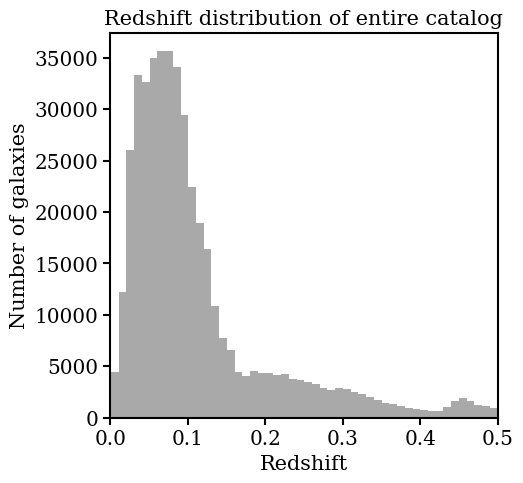

In [114]:
plt.figure(figsize=(5,5))
plt.hist(main_clean['Z'], bins=50, histtype='stepfilled', color='darkgrey')
plt.xlim([0,0.5])
plt.xlabel("Redshift",fontsize = 15)
plt.ylabel("Number of galaxies",fontsize = 15)
plt.title("Redshift distribution of entire catalog",fontsize=15)
plt.show()

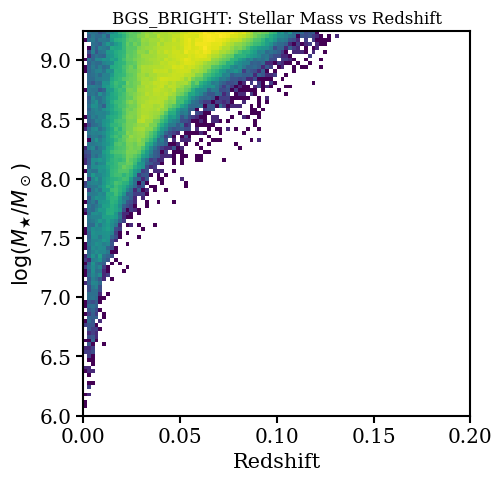

In [131]:
mask_bgs_bright = (main_clean['SAMPLE'] == 'BGS_BRIGHT')

plt.figure(figsize=(5,5))
plt.hist2d(
    main_clean['Z'][mask_bgs_bright],
    main_clean['LOG_MSTAR_M24'][mask_bgs_bright],
    cmap = "viridis", norm=LogNorm(), range=((0,0.2),(6,9.25)),bins=100
)

plt.xlabel(r"Redshift",fontsize = 15)
plt.ylabel(r"$\log(M_{\bigstar} / M_\odot)$",fontsize = 15)
plt.title("BGS_BRIGHT: Stellar Mass vs Redshift")
plt.show()




In [128]:
mask_bgs_faint = (main_clean['SAMPLE'] == 'BGS_FAINT')
mask_lowz = (main_clean['SAMPLE'] == 'LOWZ')
mask_elg = (main_clean['SAMPLE'] == 'ELG')


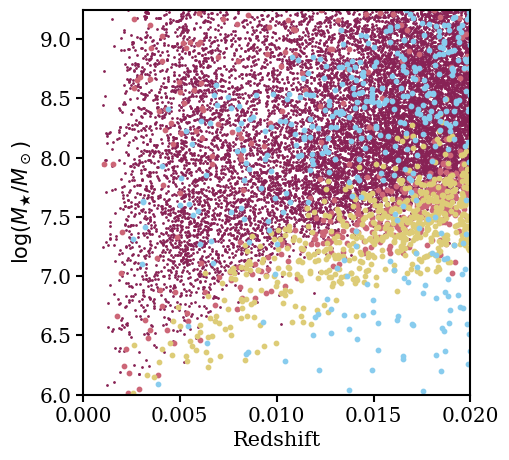

In [138]:

sample_colors = {"BGS_BRIGHT" : "#882255", "BGS_FAINT": "#CC6677", "LOWZ":"#DDCC77", "ELG": "#88CCEE" }

plt.figure(figsize=(5,5))

plt.scatter(
    main_clean['Z'][mask_bgs_bright],
    main_clean['LOG_MSTAR_M24'][mask_bgs_bright],
    s=1,alpha=1,color = sample_colors["BGS_BRIGHT"])

plt.scatter(
    main_clean['Z'][mask_bgs_faint],
    main_clean['LOG_MSTAR_M24'][mask_bgs_faint],
    s=10,alpha=1,color = sample_colors["BGS_FAINT"])

plt.scatter(
    main_clean['Z'][mask_lowz],
    main_clean['LOG_MSTAR_M24'][mask_lowz],
    s=10,alpha=1,color = sample_colors["LOWZ"])

plt.scatter(
    main_clean['Z'][mask_elg],
    main_clean['LOG_MSTAR_M24'][mask_elg],
    s=10,alpha=1,color = sample_colors["ELG"])


plt.xlim([0,0.02])
plt.ylim([6,9.25])
plt.xlabel(r"Redshift",fontsize = 15)
plt.ylabel(r"$\log(M_{\bigstar} / M_\odot)$",fontsize = 15)
plt.show()


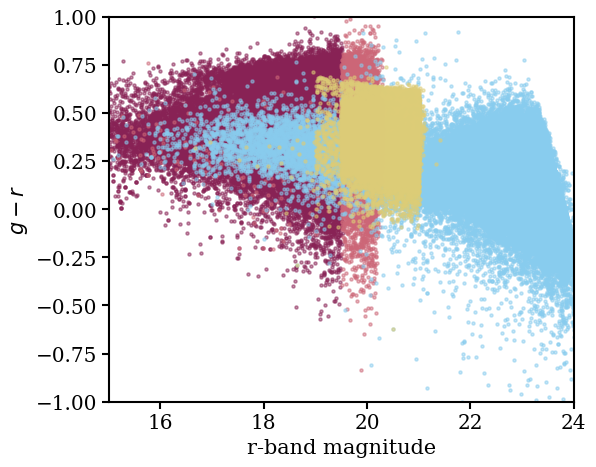

In [149]:
samples = np.unique(main_clean['SAMPLE'])

plt.figure(figsize=(6,5))

for s in samples:
    mask = main_clean['SAMPLE'] == s
    plt.scatter(
        main_clean['MAG_R'][mask],
        main_clean['MAG_G'][mask] - main_clean['MAG_R'][mask],  # g-r
        s=5, alpha=0.5, color=sample_colors[s], label=s
    )

plt.ylabel(r"$g - r$",fontsize = 15)
plt.xlabel(r"r-band magnitude",fontsize = 15)
plt.xlim([15,24])
plt.ylim([-1,1])
plt.show()

## FASTSPEC Extension

The `FASTSPEC` extension contains measurements of spectral features derived from the **Fastspecfit** code.  
For more details on the methodology and available quantities, see the official documentation: [Fastspecfit Documentation](https://fastspecfit.readthedocs.io/en/latest/index.html).

This extension includes:

- **Continuum indices** (e.g., `DN4000`)  
- **Emission-line fluxes and inverse variances** (`OII_3726_FLUX`, `HALPHA_FLUX`, etc.)  
- **Aperture corrections** (`APERCORR_*`)  
- **Signal-to-noise per camera** (`SNR_B`, `SNR_R`, `SNR_Z`)  
- **Broad and narrow emission line parameters** (`HALPHA_BROAD_FLUX`, `HALPHA_SIGMA`)

Each column is documented with units and description in the FITS header.

Note: Be cautious when applying line flux SNR cuts. In some cases, the measured flux can still be unphysically small even if the SNR appears high, due to very large inverse variance. (Need to ask John Moustakas about this)


In [82]:
oiii_5007_snr = (fastspec["OIII_5007_FLUX"] * np.sqrt(fastspec["OIII_5007_FLUX_IVAR"]) > 5)
hbeta_snr = (fastspec["HBETA_FLUX"] * np.sqrt(fastspec["HBETA_FLUX_IVAR"])  > 5)
halpha_snr = (fastspec["HALPHA_FLUX"] * np.sqrt(fastspec["HALPHA_FLUX_IVAR"])  > 5)
nii_6584_snr = (fastspec["NII_6584_FLUX"] * np.sqrt(fastspec["NII_6584_FLUX_IVAR"])  > 5)

snr_mask = oiii_5007_snr & hbeta_snr & halpha_snr & nii_6584_snr

fastspec_bpt = fastspec[snr_mask]


In [83]:

# Compute common line ratios (log scale)
OIII_Hb = np.log10(fastspec_bpt["OIII_5007_FLUX"] / fastspec_bpt["HBETA_FLUX"])
NII_Ha  = np.log10(fastspec_bpt["NII_6584_FLUX"] / fastspec_bpt["HALPHA_FLUX"])

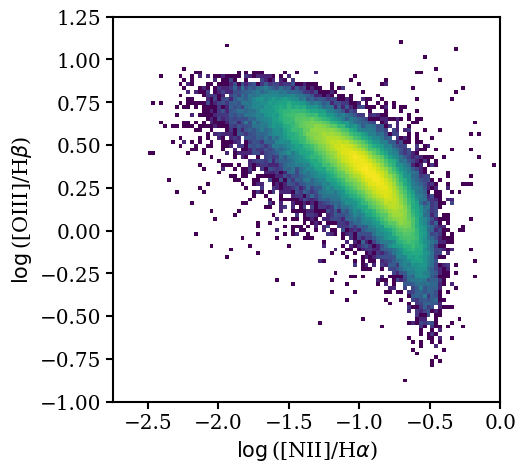

In [92]:

plt.figure(figsize=(5, 5))
plt.hist2d(NII_Ha, OIII_Hb, cmap="viridis",range=((-2.75,0), (-1,1.25)), bins=100,norm=LogNorm())
plt.xlabel(r"$\log$([NII]/H$\alpha$)",fontsize = 15)
plt.ylabel(r"$\log$([OIII]/H$\beta$)",fontsize = 15)
plt.xlim([-2.75,0])
plt.ylim([-1,1.25])
plt.show()

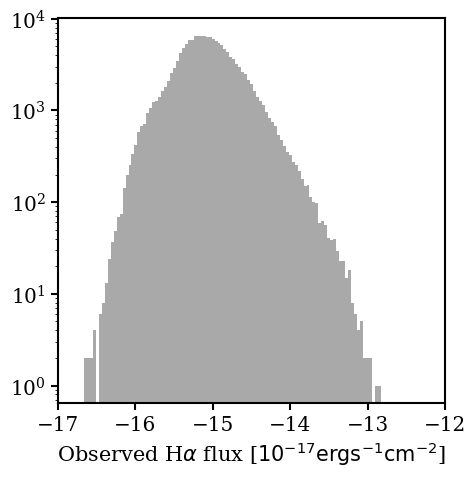

In [166]:

plt.figure(figsize=(5, 5))
plt.hist(np.log10(fastspec_bpt["HALPHA_FLUX"] * 1e-17),bins=100,color = "darkgrey" )
plt.yscale("log")
plt.xlim([-17,-12])
plt.xlabel(r"Observed H$\alpha$ flux [$10^{-17}\mathrm{erg s^{-1} cm^{-2}}$]",fontsize = 15)
plt.show()

In [167]:
hei_5876_snr = (fastspec["HEI_5876_FLUX"] * np.sqrt(fastspec["HEI_5876_FLUX_IVAR"]) > 5) & (fastspec["HEI_5876_FLUX"] > 1 )


In [168]:
fastspec_f = fastspec[ snr_mask & hei_5876_snr ]

hei_hbeta_ratio = np.log10(fastspec_f["HEI_5876_FLUX"] / fastspec_f["HBETA_FLUX"]   )

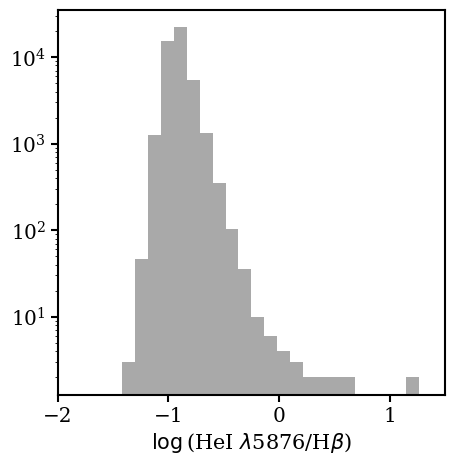

In [173]:

plt.figure(figsize=(5, 5))
plt.hist(hei_hbeta_ratio,range=(-2,1.5),bins=30, color = "darkgrey" )
plt.yscale("log")
plt.xlim([-2,1.5])
plt.xlabel(r"$\log$(HeI $\lambda$5876/H$\beta$)",fontsize = 15)
plt.show()